In [1]:
import os
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr

In [2]:
parent = os.path.join(Path(os.getcwd()).parent)

print(parent)

sys.path.append(parent)

c:\Users\bruij_kn\OneDrive - Stichting Deltares\Documents\GitHub\thermo-morphological-model


In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

In [5]:
# reference variables
per_sa = {
    "start_time": pd.to_datetime("2018-01-01"), # these dates are relevant for the bluff edge only
    "end_time": pd.to_datetime("2019-01-01"),
}

I need:
- I need to extract total erosion of each variable, and check against baseline
- A way to differentiate between different types of tested variables

==> pd.DataFrame with columns for runid, sensitivity analysis level, sublevel, total erosion, and total erosion over baseline erosion.

In [6]:
# load overview dataframe
fpath_overview = Path("overview_sa.csv")
df = pd.read_csv(fpath_overview)

# get values for base run
fpath_base = Path("erosion_rates/sa_base.csv")
df_base = pd.read_csv(fpath_base, parse_dates=['time'])

x_start_base = df_base['x_bluff_edge'].values[0]
x_end_base = df_base['x_bluff_edge'].values[-1]
total_bluff_erosion_base = x_end_base - x_start_base

# initialize erosion
total_erosion = []
rnte = [] # relative normalized total erosion

# loop through all parameters
for i, row in df.iterrows():
    runid_low = row['run_id_low']
    runid_high = row['run_id_high']
    
    try:
        df_low = pd.read_csv(Path(f'erosion_rates/{runid_low}.csv'), parse_dates=['time'])
        df_high = pd.read_csv(Path(f'erosion_rates/{runid_high}.csv'), parse_dates=['time'])

        x_start_low = df_low['x_bluff_edge'].values[0]
        x_start_high = df_high['x_bluff_edge'].values[0]
        
        x_end_low = df_low['x_bluff_edge'].values[-1]
        x_end_high = df_high['x_bluff_edge'].values[-1]
        
        total_erosion_low = x_end_low - x_start_low
        total_erosion_high = x_end_high - x_start_high
        
        rnte_low = total_erosion_low / total_bluff_erosion_base
        rnte_high = total_erosion_high / total_bluff_erosion_base
        
        total_erosion.append((total_erosion_low, total_erosion_high))
        rnte.append((rnte_low, rnte_high))
    
    except FileNotFoundError:
        total_erosion.append((0, 0))
        rnte.append((0, 0))

    
# add new columns
total_erosion = np.array(total_erosion)
rnte = np.array(rnte)

df['total_erosion_low[m]'] = total_erosion[:,0]
df['total_erosion_high[m]'] = total_erosion[:,1]

df['rnte_low[-]'] = rnte[:,0]
df['rnte_high[-]'] = rnte[:,1]

df.dropna(inplace=True, axis=0)

# df

In [7]:
df_volume_changes = pd.read_csv("volume_changes.csv")

# df_volume_changes

In [8]:
volume_change_base = df_volume_changes[df_volume_changes.runid=='sa_base']['dV[m2]'].values[0]

volume_start_low = []
volume_end_low = []
volume_change_low = []

volume_start_high = []
volume_end_high = []
volume_change_high = []

for runid in df.run_id_low.values:
    volume_start_low.append(df_volume_changes[df_volume_changes.runid==runid]['V_start[m2]'].values[0])
    volume_end_low.append(df_volume_changes[df_volume_changes.runid==runid]['V_end[m2]'].values[0])
    volume_change_low.append(df_volume_changes[df_volume_changes.runid==runid]['dV[m2]'].values[0])
    
for runid in df.run_id_high.values:
    volume_start_high.append(df_volume_changes[df_volume_changes.runid==runid]['V_start[m2]'].values[0])
    volume_end_high.append(df_volume_changes[df_volume_changes.runid==runid]['V_end[m2]'].values[0])
    volume_change_high.append(df_volume_changes[df_volume_changes.runid==runid]['dV[m2]'].values[0])
    
df['volume_start_low[m2]'] = volume_start_low
df['volume_end_low[m2]'] = volume_end_low
df['volume_change_low[m2]'] = volume_change_low
df['volume_loss_low[m2]'] = -np.array(volume_change_low)

df['volume_start_high[m2]'] = volume_start_high
df['volume_end_high[m2]'] = volume_end_high
df['volume_change_high[m2]'] = volume_change_high
df['volume_loss_high[m2]'] = -np.array(volume_change_high)


In [9]:
# display(df)
display(df.tail())

print(len(df))

,varied_parameter,level,sublevel,number_low,number_high,baseline_value,unit,variation,new_value_low,new_value_high,...,rnte_low[-],rnte_high[-],volume_start_low[m2],volume_end_low[m2],volume_change_low[m2],volume_loss_low[m2],volume_start_high[m2],volume_end_high[m2],volume_change_high[m2],volume_loss_high[m2]
40,Sea temperature*,2.0,thermodynamics,13.0,14.0,0.0,-,+-2,-2,+2,...,1.0,1.0,1379.25,1329.486770,-49.763230,49.763230,1379.25,1327.762577,-51.487423,51.487423
41,2m air temperature*,2.0,thermodynamics,15.0,16.0,0.0,-,+-2,-2,+2,...,1.0,1.0,1379.25,1351.533047,-27.716953,27.716953,1379.25,1327.126475,-52.123525,52.123525
42,Latent heat flux,2.0,thermodynamics,17.0,18.0,1.0,-,+-10%,*0.9,*1.1,...,1.0,1.0,1379.25,1329.373634,-49.876366,49.876366,1379.25,1329.510277,-49.739723,49.739723
43,Thermal module,3.0,thermal-module,1.0,1.0,1.0,-,-1,0,0,...,2.0,2.0,1379.25,1277.034569,-102.215431,102.215431,1379.25,1277.034569,-102.215431,102.215431
44,Solar flux calcuator,3.0,thermal-module,2.0,2.0,1.0,-,-1,0,0,...,1.0,1.0,1379.25,1328.566210,-50.683790,50.683790,1379.25,1328.566210,-50.683790,50.683790


45


In [10]:
# order dataframe from low to high (choose between which parameter I want to order)
df['erosion_diff[m]'] = np.abs(df['total_erosion_high[m]'].values - df['total_erosion_low[m]'].values)
df['volume_change_diff[m2]'] = np.abs(df['volume_change_high[m2]'].values - df['volume_change_low[m2]'].values)
df['volume_change_total[m2]'] = np.abs(df['volume_change_high[m2]'].values - volume_change_base) +  np.abs(df['volume_change_low[m2]'].values - volume_change_base)

df = df.sort_values('volume_change_total[m2]')

In [11]:
display(df.head())
display(df.tail())

,varied_parameter,level,sublevel,number_low,number_high,baseline_value,unit,variation,new_value_low,new_value_high,...,volume_end_low[m2],volume_change_low[m2],volume_loss_low[m2],volume_start_high[m2],volume_end_high[m2],volume_change_high[m2],volume_loss_high[m2],erosion_diff[m],volume_change_diff[m2],volume_change_total[m2]
7,offshore_slope,1.0,bathymetry,15.0,16.0,0.007,-,+-20%,0.0056,0.0084,...,1329.483733,-49.766267,49.766267,1379.25,1329.453178,-49.796822,49.796822,0.0,0.030555,0.071116
9,sea_ice_threshold,1.0,model,19.0,20.0,0.850,-,+-10%,0.765,0.935,...,1329.566614,-49.683386,49.683386,1379.25,1329.513955,-49.736045,49.736045,0.0,0.052659,0.072541
13,grid_resolution_xb,1.0,model,27.0,28.0,40.000,ppwl,+-10%,36,44,...,1329.484193,-49.765807,49.765807,1379.25,1329.575574,-49.674426,49.674426,0.0,0.091381,0.091381
12,surface_flux_angle,1.0,model,25.0,26.0,20.000,degrees,+-10%,18,22,...,1329.469832,-49.780168,49.780168,1379.25,1329.444214,-49.805786,49.805786,0.0,0.025618,0.093982
11,surface_flux_factor,1.0,model,23.0,24.0,1.000,-,+-10%,0.9,1.1,...,1329.526352,-49.723648,49.723648,1379.25,1329.402978,-49.847022,49.847022,0.0,0.123373,0.123373


,varied_parameter,level,sublevel,number_low,number_high,baseline_value,unit,variation,new_value_low,new_value_high,...,volume_end_low[m2],volume_change_low[m2],volume_loss_low[m2],volume_start_high[m2],volume_end_high[m2],volume_change_high[m2],volume_loss_high[m2],erosion_diff[m],volume_change_diff[m2],volume_change_total[m2]
41,2m air temperature*,2.0,thermodynamics,15.0,16.0,0.00,-,+-2,-2,+2,...,1351.533047,-27.716953,27.716953,1379.25,1327.126475,-52.123525,52.123525,0.0,24.406572,24.406572
31,Tm,1.0,physical,63.0,64.0,273.15,K,+-1%,270.4185,275.8815,...,1324.690730,-54.559270,54.559270,1379.25,1352.656602,-26.593398,26.593398,4.0,27.965872,27.965872
1,bluff_slope,1.0,bathymetry,3.0,4.0,1.00,-,+-20%,0.8,1.2,...,1376.469881,-22.080119,22.080119,1376.85,1322.843752,-54.006248,54.006248,4.0,31.926130,31.926130
18,dryslp,1.0,physical,37.0,38.0,1.00,-,+-20%,0.8,1.2,...,1320.425670,-58.824330,58.824330,1379.25,1353.089584,-26.160416,26.160416,4.0,32.663914,32.663914
43,Thermal module,3.0,thermal-module,1.0,1.0,1.00,-,-1,0,0,...,1277.034569,-102.215431,102.215431,1379.25,1277.034569,-102.215431,102.215431,0.0,0.000000,104.938890


We can make a tornado plot out of this!

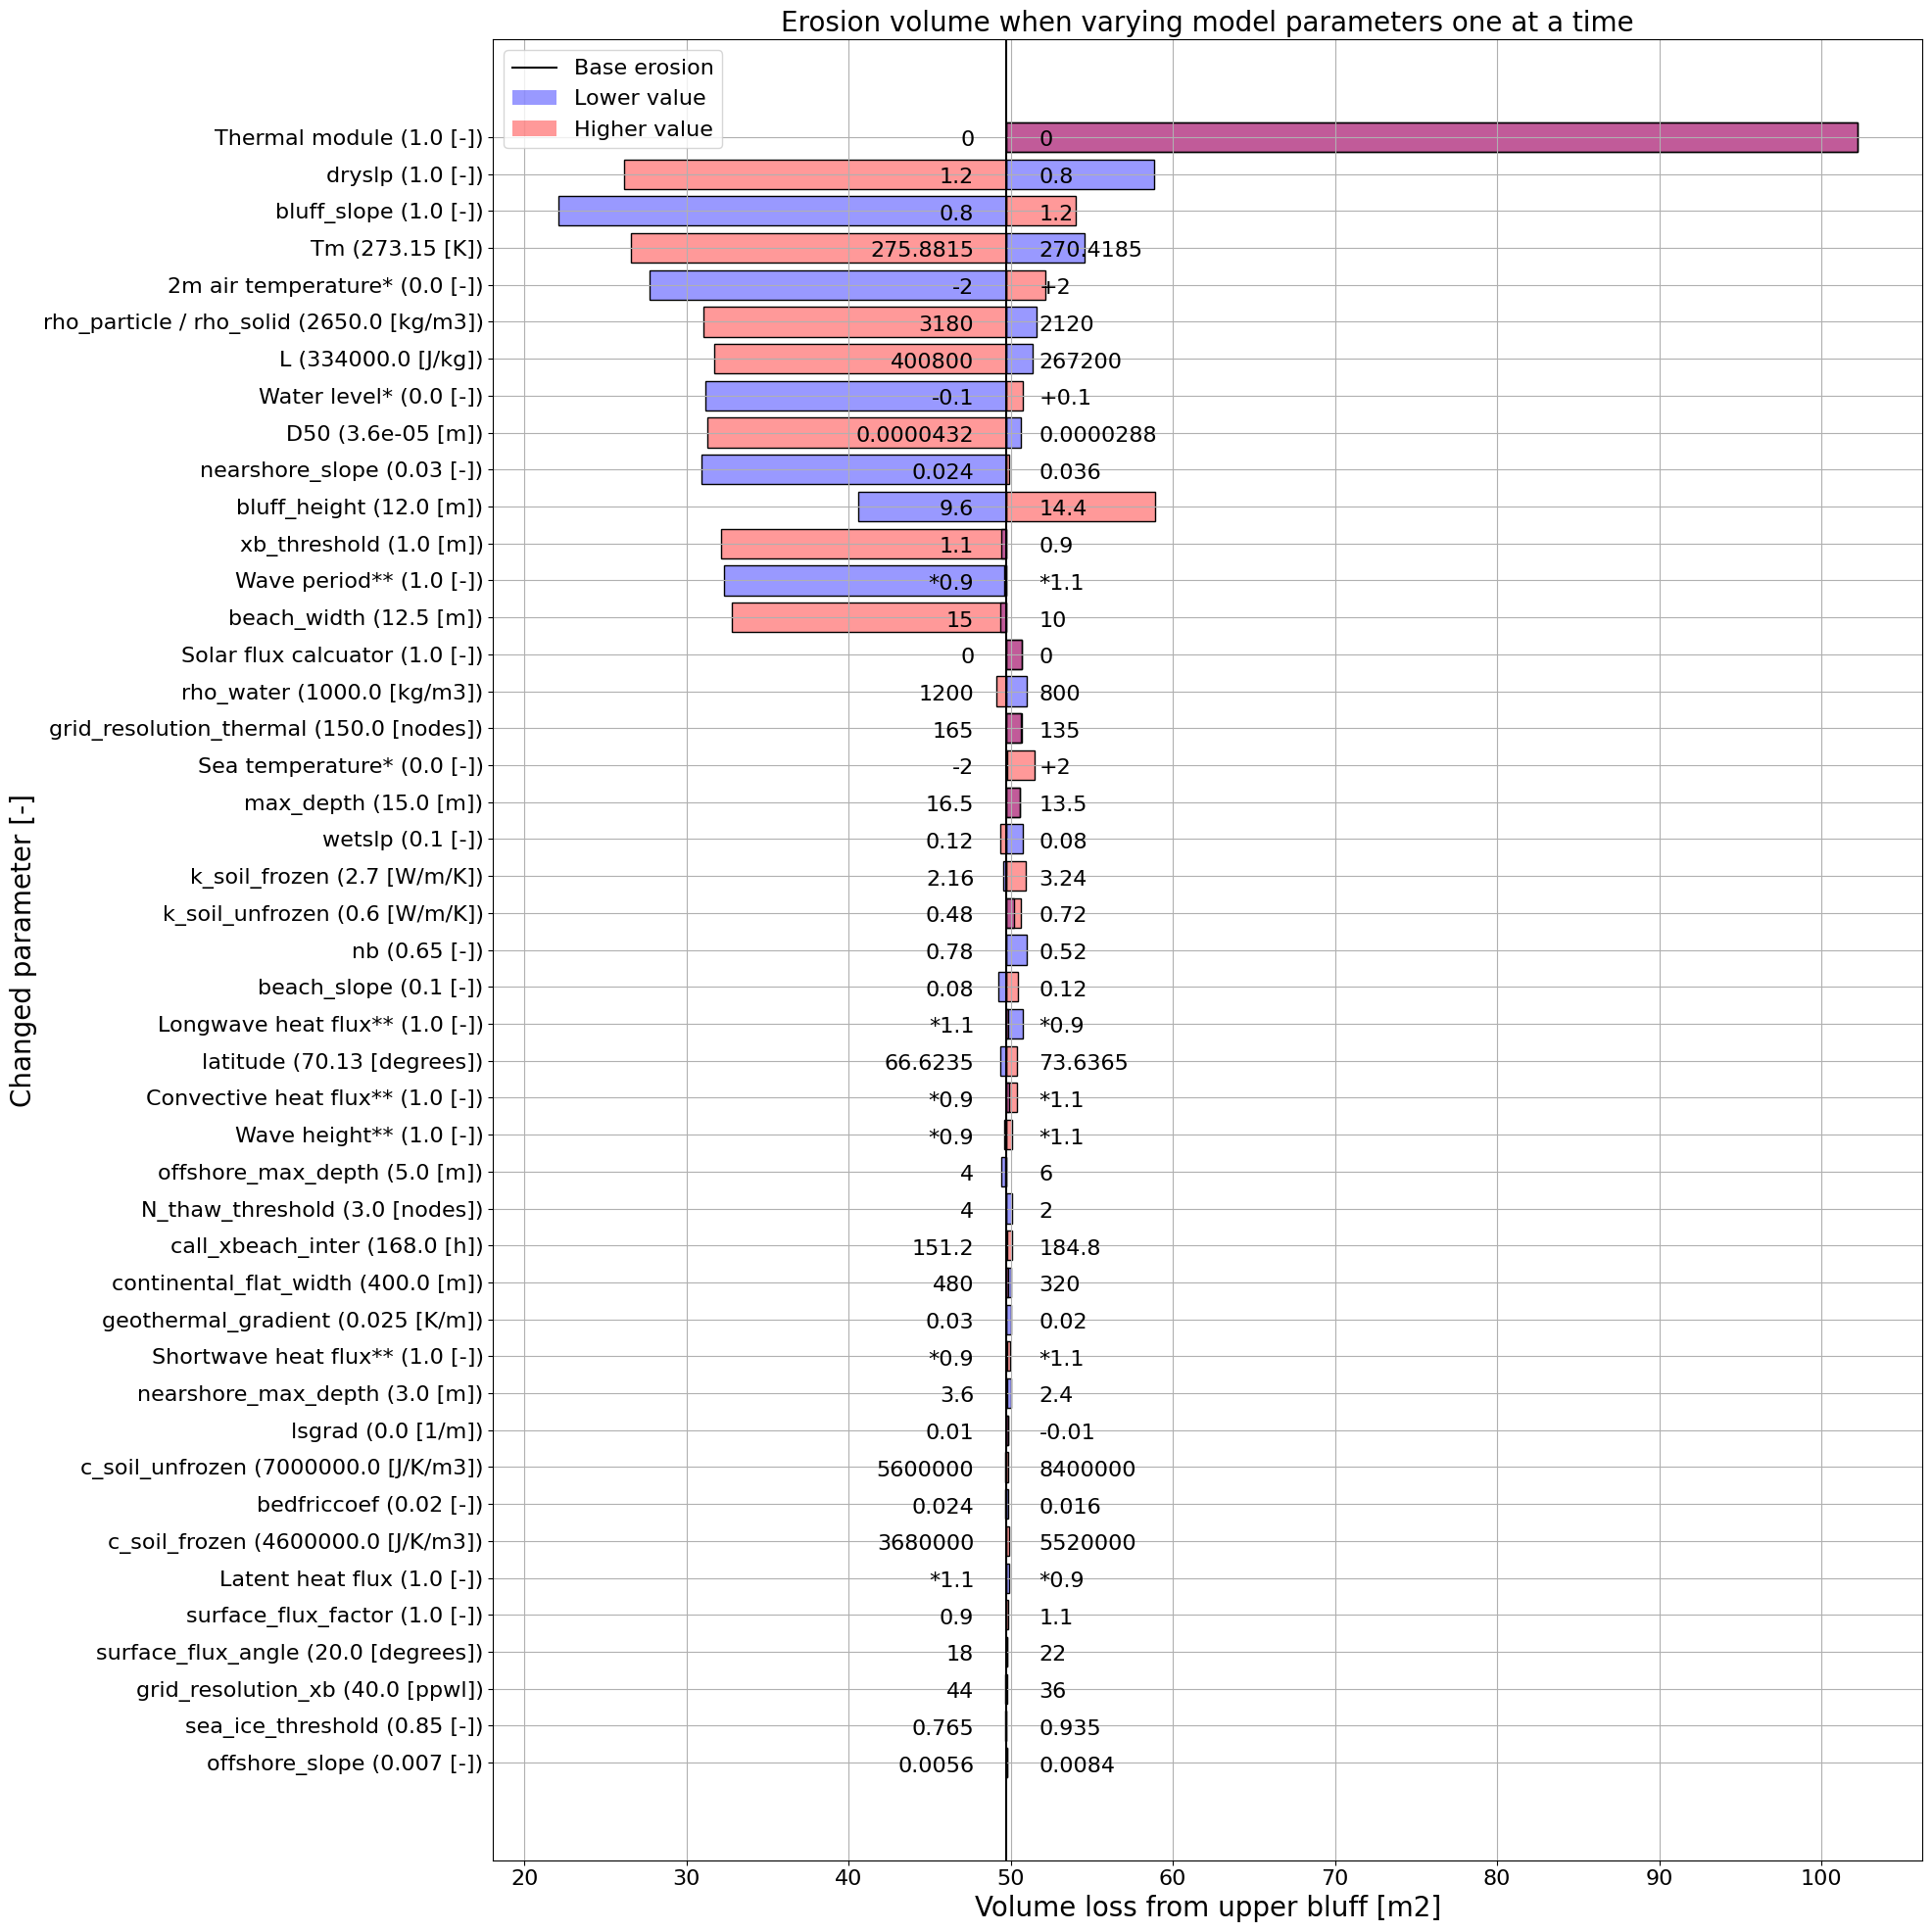

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))

# x_left = total_bluff_erosion_base
x_left = volume_change_base

ax.barh(np.arange(len(df)), width=df['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax.barh(np.arange(len(df)), width=df['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
outline1 = ax.barh(np.arange(len(df)), width=df['volume_loss_low[m2]'].values + x_left, left=-x_left, facecolor='None', edgecolor='k')
outline2 = ax.barh(np.arange(len(df)), width=df['volume_loss_high[m2]'].values + x_left, left=-x_left, facecolor='None', edgecolor='k')

# outline1.set_facecolor(None)

labels = [f'{df['varied_parameter'].values[i]} ({df['baseline_value'].values[i]} [{df['unit'].values[i]}])' for i in range(len(df))]
ax.set_yticks(np.arange(len(df)), labels)

for i in range(len(df)):
        
        if df['volume_loss_low[m2]'].values[i] <= df['volume_loss_high[m2]'].values[i]:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] - 5
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] + 1
            
            loc_low = -volume_change_base - 2
            loc_high = -volume_change_base + 2
            
            allignment_low = 'right'
            allignment_high = 'left'
        else:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] + 1
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] - 5
            
            loc_low = -volume_change_base + 2
            loc_high = -volume_change_base - 2
            
            allignment_low = 'left'
            allignment_high = 'right'
                
        ax.text(loc_low, np.arange(len(df))[i]-0.25, df['new_value_low'].values[i], horizontalalignment=allignment_low)
        ax.text(loc_high, np.arange(len(df))[i]-0.25, df['new_value_high'].values[i], horizontalalignment=allignment_high)

ax.axvline(-x_left, color='k', label='Base erosion')

ax.grid()

ax.set_title('Erosion volume when varying model parameters one at a time')

ax.legend()

ax.set_xlabel('Volume loss from upper bluff [m2]')
ax.set_ylabel('Changed parameter [-]')

fig.tight_layout()

figname = 'SA_all.png'

fig.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

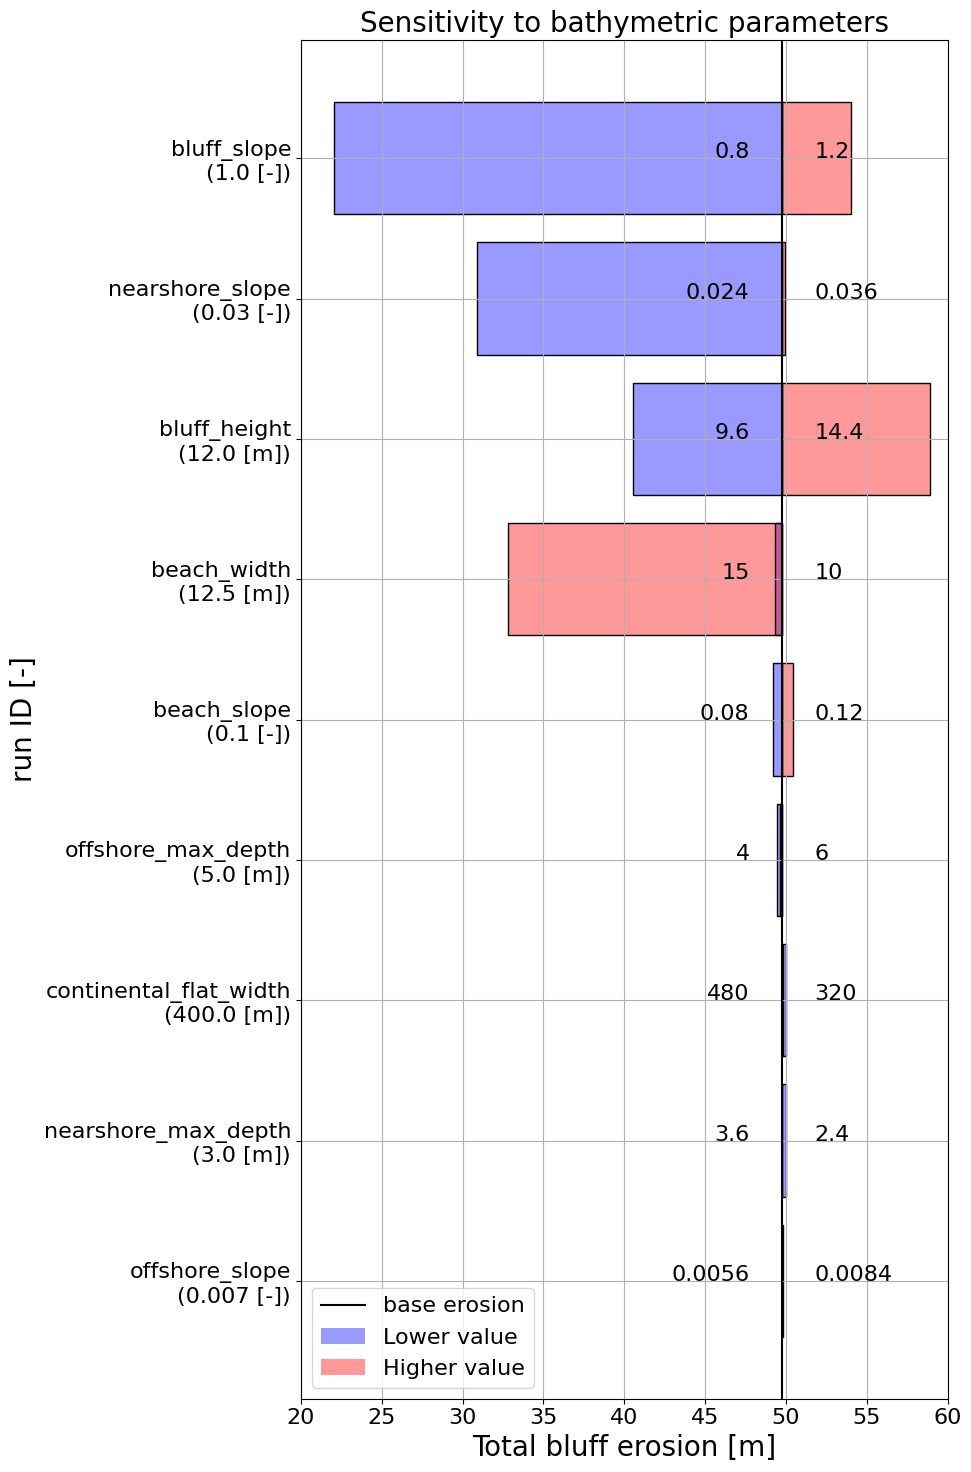

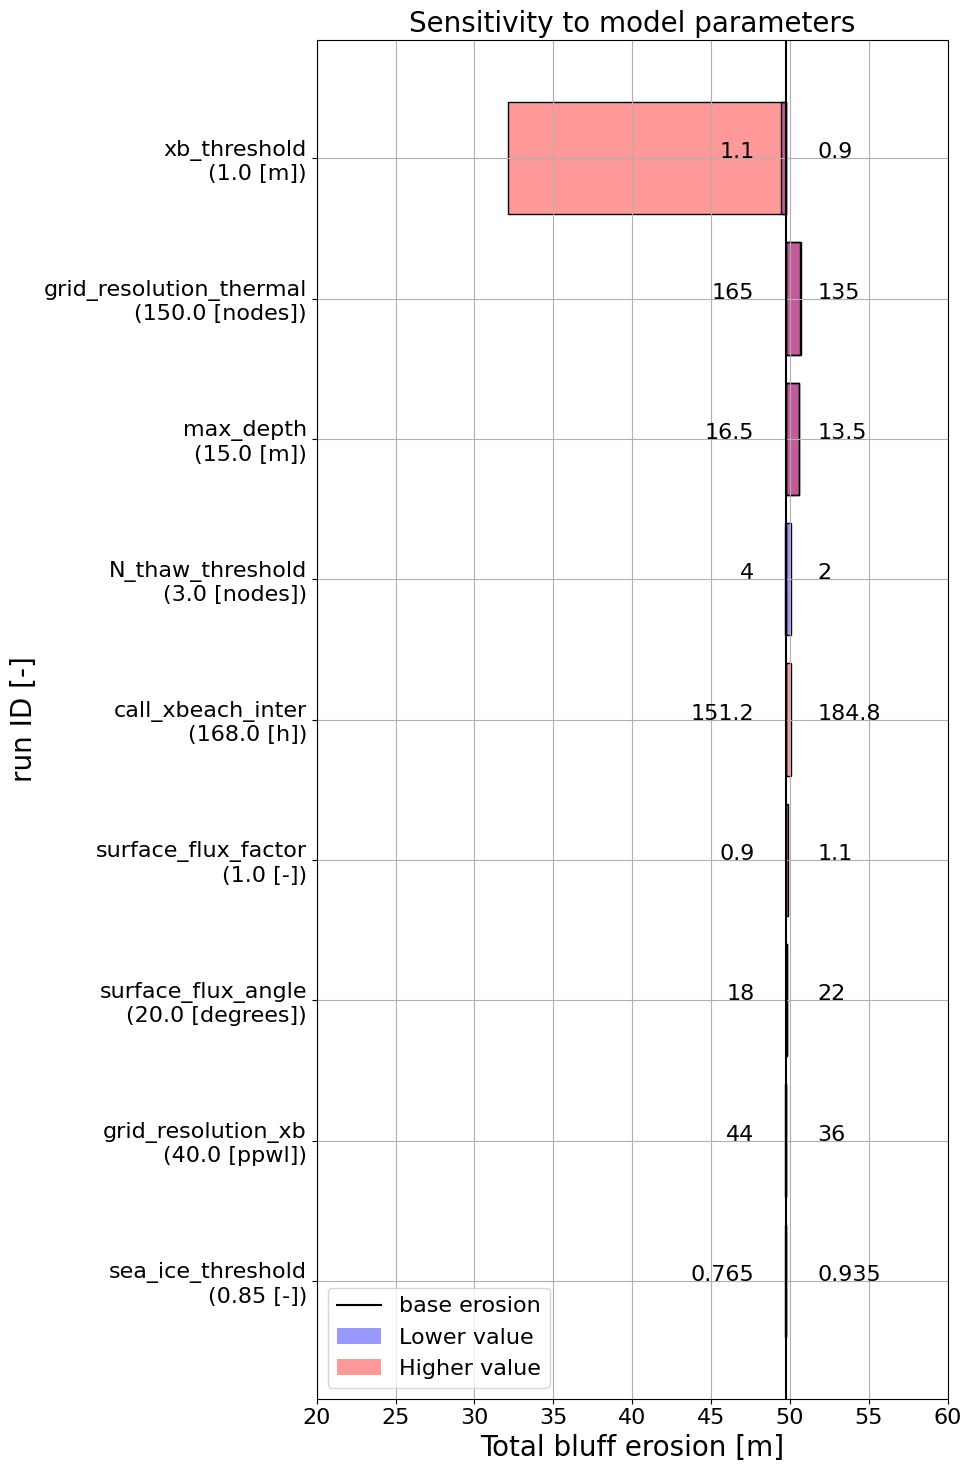

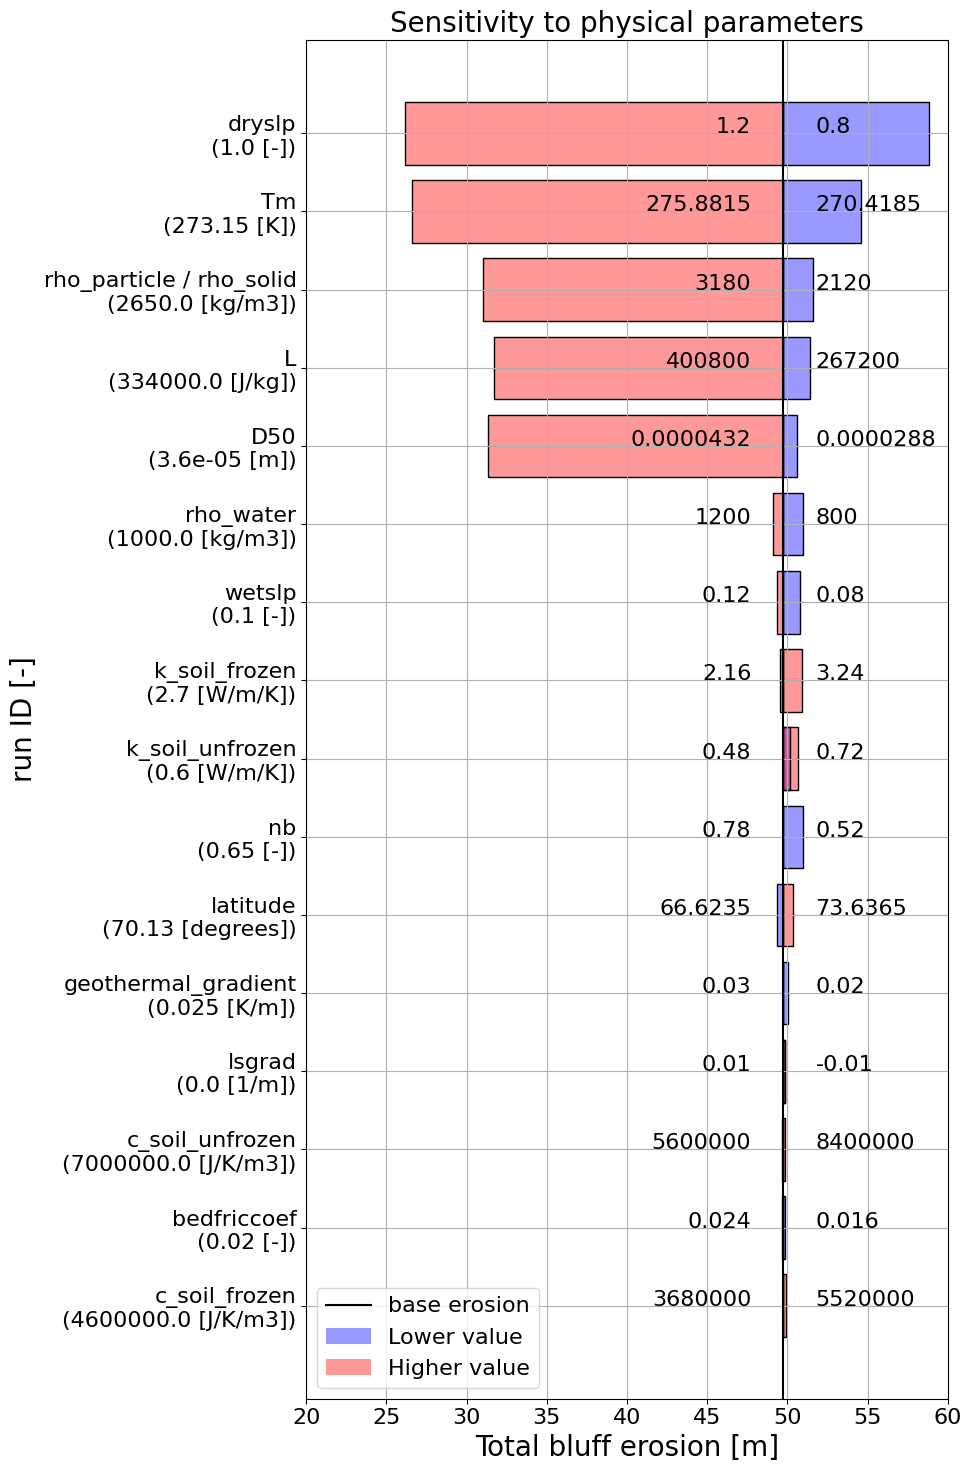

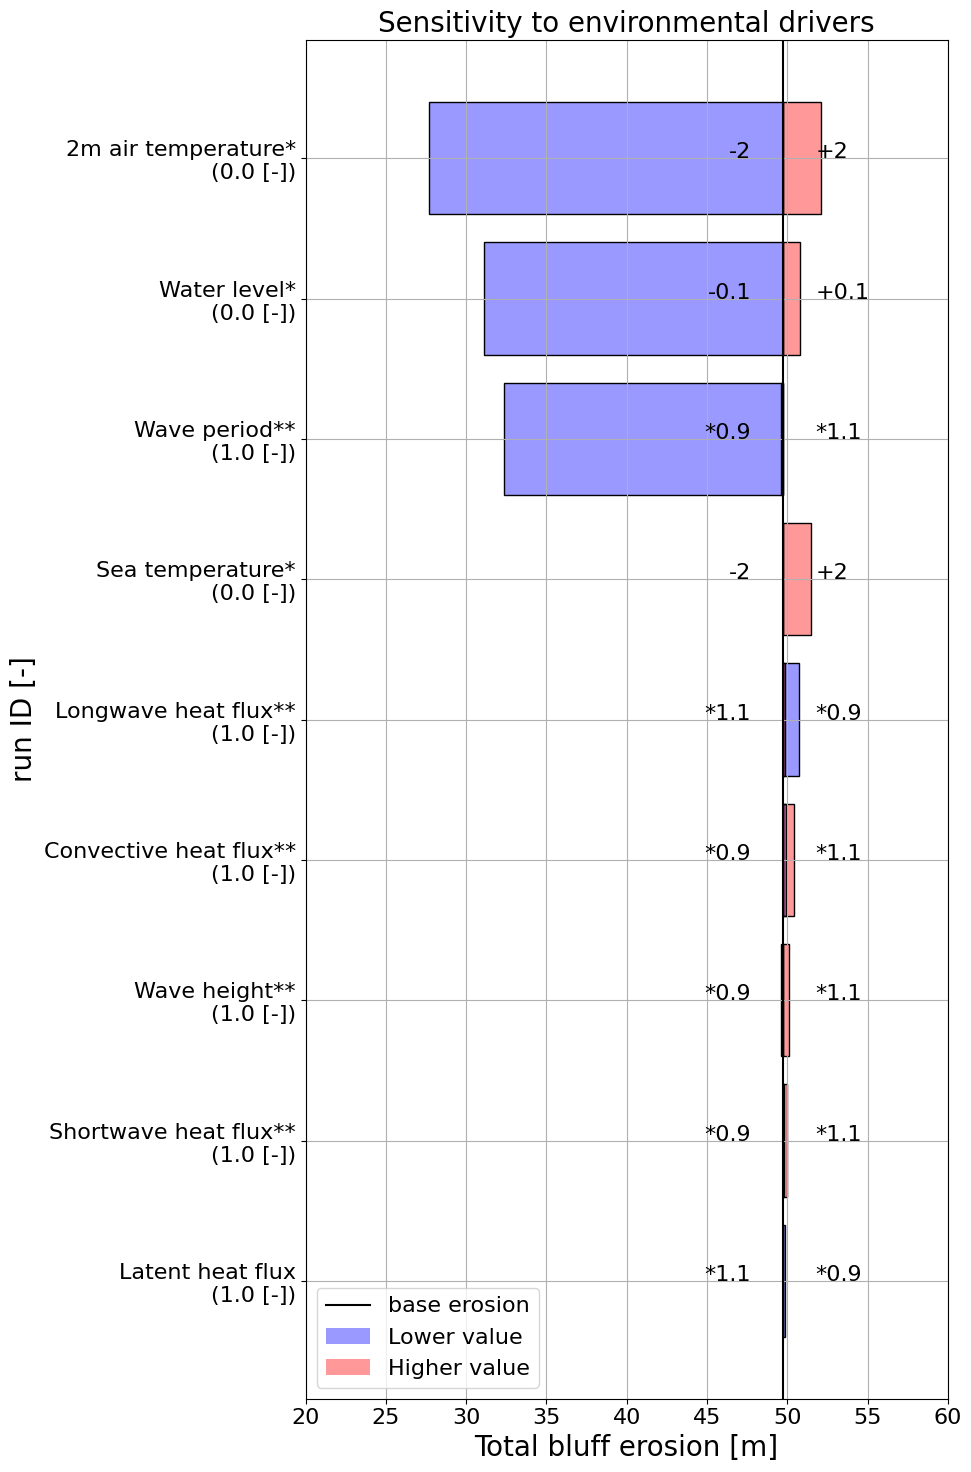

In [22]:
figsize = (10, 15)

fig0, ax0 = plt.subplots(figsize=figsize)
fig1, ax1 = plt.subplots(figsize=figsize)
fig2, ax2 = plt.subplots(figsize=figsize)
fig3, ax3 = plt.subplots(figsize=figsize)

# fig, axs = plt.subplots(2,2, figsize=(6, 6))

df_bathy = df[df['sublevel']=='bathymetry']
df_model = df[df['sublevel']=='model']
df_physi = df[df['sublevel']=='physical']
df_envir = df[(df['sublevel']=='hydrodynamics') | (df['sublevel']=='thermodynamics')]
# df_therm = df[df['sublevel']=='thermodynamics']

x_left = volume_change_base

ax0.barh(np.arange(len(df_bathy)), width=df_bathy['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax0.barh(np.arange(len(df_bathy)), width=df_bathy['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax0.barh(np.arange(len(df_bathy)), width=df_bathy['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax0.barh(np.arange(len(df_bathy)), width=df_bathy['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')

ax1.barh(np.arange(len(df_model)), width=df_model['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax1.barh(np.arange(len(df_model)), width=df_model['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax1.barh(np.arange(len(df_model)), width=df_model['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax1.barh(np.arange(len(df_model)), width=df_model['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')

ax2.barh(np.arange(len(df_physi)), width=df_physi['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax2.barh(np.arange(len(df_physi)), width=df_physi['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax2.barh(np.arange(len(df_physi)), width=df_physi['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax2.barh(np.arange(len(df_physi)), width=df_physi['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')

ax3.barh(np.arange(len(df_envir)), width=df_envir['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax3.barh(np.arange(len(df_envir)), width=df_envir['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax3.barh(np.arange(len(df_envir)), width=df_envir['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax3.barh(np.arange(len(df_envir)), width=df_envir['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')

# axs[1, 1].barh(np.arange(len(df_therm)), width=df_therm['total_erosion_low[m]'].values, left=x_left, label='thermo Low', color='y')
# axs[1, 1].barh(np.arange(len(df_therm)), width=df_therm['total_erosion_high[m]'].values, left=x_left, label='thermo High', color='g')

for ax in [ax0, ax1, ax2, ax3]:
    ax.axvline(-x_left, color='k', label='base erosion')

    ax.grid()

    ax.legend(loc='lower left')

    ax.set_xlabel('Total bluff erosion [m]')
    ax.set_ylabel('run ID [-]')
    
    ax.set_xlim((20, 60))

ax0.set_title('Sensitivity to bathymetric parameters')
ax1.set_title('Sensitivity to model parameters')
ax2.set_title('Sensitivity to physical parameters')
ax3.set_title('Sensitivity to environmental drivers')

labels_bathy = [f'{df_bathy['varied_parameter'].values[i]}\n({df_bathy['baseline_value'].values[i]} [{df_bathy['unit'].values[i]}])' for i in range(len(df_bathy))]
labels_model = [f'{df_model['varied_parameter'].values[i]}\n({df_model['baseline_value'].values[i]} [{df_model['unit'].values[i]}])' for i in range(len(df_model))]
labels_physi = [f'{df_physi['varied_parameter'].values[i]}\n({df_physi['baseline_value'].values[i]} [{df_physi['unit'].values[i]}])' for i in range(len(df_physi))]
labels_envir = [f'{df_envir['varied_parameter'].values[i]}\n({df_envir['baseline_value'].values[i]} [{df_envir['unit'].values[i]}])' for i in range(len(df_envir))]

ax0.set_yticks(np.arange(len(df_bathy)), labels_bathy)
ax1.set_yticks(np.arange(len(df_model)), labels_model)
ax2.set_yticks(np.arange(len(df_physi)), labels_physi)
ax3.set_yticks(np.arange(len(df_envir)), labels_envir)

for dfi, ax in zip([df_bathy, df_model, df_physi, df_envir], [ax0, ax1, ax2, ax3]):

    for i in range(len(dfi)):
        
        if dfi['volume_loss_low[m2]'].values[i] <= dfi['volume_loss_high[m2]'].values[i]:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] - 5
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] + 1
            
            loc_low = -volume_change_base - 2
            loc_high = -volume_change_base + 2
            
            allignment_low = 'right'
            allignment_high = 'left'
        else:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] + 1
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] - 5
            
            loc_low = -volume_change_base + 2
            loc_high = -volume_change_base - 2
            
            allignment_low = 'left'
            allignment_high = 'right'
                
        ax.text(loc_low, np.arange(len(dfi))[i], dfi['new_value_low'].values[i], horizontalalignment=allignment_low)
        ax.text(loc_high, np.arange(len(dfi))[i], dfi['new_value_high'].values[i], horizontalalignment=allignment_high)

fig0.tight_layout()
fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

figname0 = 'SA_ordered_bathy.png'
figname1 = 'SA_ordered_model.png'
figname2 = 'SA_ordered_physi.png'
figname3 = 'SA_ordered_envir.png'

fig0.savefig(os.path.join(save_path, figname0), bbox_inches='tight', facecolor='white', transparent=False)
fig1.savefig(os.path.join(save_path, figname1), bbox_inches='tight', facecolor='white', transparent=False)
fig2.savefig(os.path.join(save_path, figname2), bbox_inches='tight', facecolor='white', transparent=False)
fig3.savefig(os.path.join(save_path, figname3), bbox_inches='tight', facecolor='white', transparent=False)
